In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
from scipy.optimize import curve_fit

# for maximum likelihood
import lmfit 
import corner

# Introduction

This notebook aims to model my own estradiol serum concentration from blood test results over the past few months.

We start with a 3-compartment linear pharmacokinetic model, then derive the theoretical serum estradiol concentration from the model for completeness (as well as for the learning experience in solving differential equations using Laplace transform).

[An Informal Meta-Analysis of Estradiol Curves with Injectable Estradiol Preparations](https://transfemscience.org/articles/injectable-e2-meta-analysis/) by Aly from Transfeminine Science included a model of serum estradiol for a given injectable estradiol regimen. However, I'm currently using various strengths of estradiol patches (a mixture of Estradot and Mylan Estradiol TDP).

The aforementioned article from Transfeminine Science uses compartment models obtained from the literature. Here, we will also use a compartment model, in particular the 3-compartment model.

# Three-Compartment Model

The compartment models have the form of the [Bateman equation](https://en.wikipedia.org/wiki/Bateman_equation) that's used in physics to describe nuclear decay rate by modeling the transition rates from one species to another. It's also an example of a classical [master equation](https://en.wikipedia.org/wiki/Master_equation) where we only have a diagonal matrix that describes the "transition" probabilities (a weird word choice here due to my first encounter with master equations come from quantum optics).

The dynamics of a simple 3-compartment model is given by a system of linear differential equations ([Sheiner et al., 1979](https://doi.org/10.1002/cpt1979253358))

\begin{align*}
    \dot D(t) &= -k_1 D(t) \\
    \dot A_{\rm eff}(t) &= k_1 D(t) - k_2 A_{\rm eff}(t) \\
    \dot E_2(t) &= k_2 A_{\rm eff}(t) - k_3 E_2(t),
\end{align*}

where $\dot{}$ denotes time derivatives, $D(t)$ is the estradiol concentration within the depot (e.g., the patch sites at $200\rm~\mu g/day$), $A_{\rm eff}$ is the (hypothetical) amount of estradiol in the effect compartment, and $E_2(t)$ is the observed serum estradiol concentration at time $t$ (the level compartment).

To solve the above system, we use Laplace transform to first annihilate the time derivatives and turn the system into a system of algebraic equations. The Laplace transform of first-order derivative $\dot f(t)$ of the function $f(t)$ is given by $$\mathcal{L}[\dot f(t)]=s\hat f(s)-f(t_0),$$ and Laplace transform is linear.

Thus, our system of differential equations in the Laplace space $s$ is

\begin{align*}
    s\hat D(s)-D(t_0) &= -k_1\hat D(s) \\
    s\hat A_{\rm eff}(s)-A_{\rm eff}(t_0) &= k_1\hat D(s)-k_2\hat A_{\rm eff}(s)\\
    s\hat E_2(s)-E_2(t_0) &= k_2\hat A_{\rm eff}(s) - k_3\hat E_2(s).
\end{align*}

After grouping like terms, we can rewrite the above system in matrix notation $$\begin{bmatrix}s+k_1 & 0 & 0 \\ -k_1 & s+k_2 & 0 \\ 0 & -k_2 & s+k_3\end{bmatrix}\begin{bmatrix}\hat D(s) \\ \hat A_{\rm eff}(s) \\ \hat E_2(s)\end{bmatrix}=\begin{bmatrix}D(t_0) \\ A_{\rm eff}(t_0) \\ E_2(t_0) \end{bmatrix}.$$

Next, to solve this algebraic system in Laplace space $s$, we use [Cramer's rule](https://en.wikipedia.org/wiki/Cramer's_rule), giving us

\begin{align*}
    \hat D(s)&=\frac{\operatorname{det}\left|\begin{matrix}D(t_0) & 0 & 0 \\ A_{\rm eff}(t_0) & s+k_2 & 0 \\ E_2(t_0) & -k_2 & s+k_3\end{matrix}\right|}{\operatorname{det}\left|\begin{matrix}s+k_1 & 0 & 0 \\ -k_1 & s+k_2 & 0 \\ 0 & -k_2 & s+k_3\end{matrix}\right|}=\frac{D(t_0)}{s+k_1} \\ \\
    \hat A_{\rm eff} &=\frac{\operatorname{det}\left|\begin{matrix}s+k_1 & D(t_0) & 0 \\ -k_1 & A_{\rm eff}(t_0) & 0 \\ 0 & E_2(t_0) & s+k_3\end{matrix}\right|}{\operatorname{det}\left|\begin{matrix}s+k_1 & 0 & 0 \\ -k_1 & s+k_2 & 0 \\ 0 & -k_2 & s+k_3\end{matrix}\right|}=\frac{k_1D(t_0)}{(s+k_1)(s+k_2)}+\frac{A_{\rm eff}(t_0)}{s+k_2} \\ \\
    \hat E_2(s)&=\frac{\operatorname{det}\left|\begin{matrix}s+k_1 & 0 & D(t_0) \\ -k_1 & s+k_2 & A_{\rm eff}(t_0) \\ 0 & -k_2 & E_2(t_0)\end{matrix}\right|}{\operatorname{det}\left|\begin{matrix}s+k_1 & 0 & 0 \\ -k_1 & s+k_2 & 0 \\ 0 & -k_2 & s+k_3\end{matrix}\right|}=\frac{k_1k_2D(t_0)}{(s+k_1)(s+k_2)(s+k_3)}+\frac{k_2A_{\rm eff}}{(s+k_2)(s+k_3)}+\frac{E_2(t_0)}{s+k_3}.
\end{align*}

$\hat E_2(s)$ is our solution to serum estradiol concentration that we can use to model the observed serum level obtained from blood tests. However, it's still in Laplace space $s$. To convert back to the time domain solution $E_2(t)$, we use [an inverse Laplace transform lookup table](https://tutorial.math.lamar.edu/Classes/DE/Laplace_Table.aspx) (as well as Wolfram|Alpha when the denominator contains a quadratic or higher-order polynomial in $s$), we thus find that

\begin{align*}
    E_2(t) = &~k_1k_2D(t_0)\left[\frac{e^{-k_1t}}{(k_1-k_2)(k_1-k_3)} - \frac{e^{-k_2t}}{(k_1-k_2)(k_2-k_3)} + \frac{e^{-k_3t}}{(k_1-k_3)(k_2-k_3)}\right] \\
    &~+k_2A_{\rm eff}(t_0)\left[-\frac{e^{-k_2t}}{k_2-k_3} + \frac{e^{-k_3t}}{k_2-k_3}\right] + E_2(t_0)e^{-k_3t},
\end{align*} which matches with the solution found on [Reddit](https://old.reddit.com/r/TransDIY/comments/18zd4qw/routine_change_to_imitate_menstrual_cycle_levels/kghcqhy/).

To model estradiol serum concentration over repeated application of estradiol patches, we consider the following, as described [here](https://old.reddit.com/r/TransDIY/comments/18zd4qw/routine_change_to_imitate_menstrual_cycle_levels/kghcqhy/):

\begin{align*}
    E_2(t) = &~k_1k_2\sum_iD_i(t_0)H(t-t_i)\left[\frac{e^{-k_1(t-t_i)}}{(k_1-k_2)(k_1-k_3)} - \frac{e^{-k_2(t-t_i)}}{(k_1-k_2)(k_2-k_3)} + \frac{e^{-k_3(t-t_i)}}{(k_1-k_3)(k_2-k_3)}\right] \\
    &~+k_2A_{\rm eff}(t_0)\left[-\frac{e^{-k_2t}}{k_2-k_3} + \frac{e^{-k_3t}}{k_2-k_3}\right] + E_2(t_0)e^{-k_3t},
\end{align*} where $t_i$ is the application time of a new patch, $D_i(t_0)$ is the total (initial) estradiol concentration of patches in a cycle (modelled as a Dirac delta), and $H(t-t_i)$ is the Heaviside function so that we can model the serum concentration over multiple patches cycles.

# Estradiol Patches Release Profiles from Literature

Estradiol patches have a non-constant release profile. For example, Mylan Estradiol TDP's mean serum estradiol concentration of $n=36$ patients from a single dose of $100\rm~\mu g$ stays at the maximum only for the first 1.5 days ([DailyMed, 2022](https://dailymed.nlm.nih.gov/dailymed/drugInfo.cfm?setid=f4efb0bf-b96f-4e20-a0f2-0806ab92b2d4)):

![](https://dailymed.nlm.nih.gov/dailymed/image.cfm?name=export-09.jpg&setid=f4efb0bf-b96f-4e20-a0f2-0806ab92b2d4)

The mean serum estradiol for 4 treatments of Estradot patches (sample size of $n=30$) similarly fluctuates over time [(Hossain et al., 2003a)](https://doi.org/10.1016/S0378-5122(03)00189-0): 

![](https://ars.els-cdn.com/content/image/1-s2.0-S0378512203001890-gr1.gif)

The authors from the Estradot study above also published another study containing further data on mean serum estradiol from three treatments of Estradot with a sample size of $n=11$ and mean serum estradiol from two treatments with a sample size of $n=30$, these are also included in our dataset [(Hossain et al., 2003b)](https://doi.org/10.1016/S0378-5122(03)00190-7). Sizes of the Estradot patches from these two studies are still applicable to date [(Ankarberg-Lindgren et al., 2019)](https://doi.org/10.1530/EC-19-0025).

We will extract data from the figures of the above studies using [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/).

In [2]:
# import and visualize data

MylanTDPDays100 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_100mcg.csv', delimiter=',', skip_header=True)
MylanTDPDays50 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_50mcg.csv', delimiter=',', skip_header=True)
MylanTDPDays25 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_25mcg.csv', delimiter=',', skip_header=True)

H2003aN30Estradot100 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_100mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot50 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_50mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot37_5 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_37.5mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot25 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_25mcg.csv', delimiter=',', skip_header=True)

H2003bN11Estradot100 = np.genfromtxt('Data/Hossain2003b_Estradot_n11/H2003b_Estradot_n11_100mcg.csv', delimiter=',', skip_header=True)
H2003bN11Estradot50 = np.genfromtxt('Data/Hossain2003b_Estradot_n11/H2003b_Estradot_n11_50mcg.csv', delimiter=',', skip_header=True)

H2003bN30Estradot50 = np.genfromtxt('Data/Hossain2003b_Estradot_n30/H2003b_Estradot_n30_50mcg.csv', delimiter=',', skip_header=True)

In [3]:
# convert Mylan data from days to hrs, Estradot data is already in hrs
# https://stackoverflow.com/questions/10394659/how-to-add-a-calculated-computed-column-in-numpy

MylanTDP100 = np.vstack((MylanTDPDays100[:,0]*24, MylanTDPDays100[:,1])).T
MylanTDP50 = np.vstack((MylanTDPDays50[:,0]*24, MylanTDPDays50[:,1])).T
MylanTDP25 = np.vstack((MylanTDPDays25[:,0]*24, MylanTDPDays25[:,1])).T

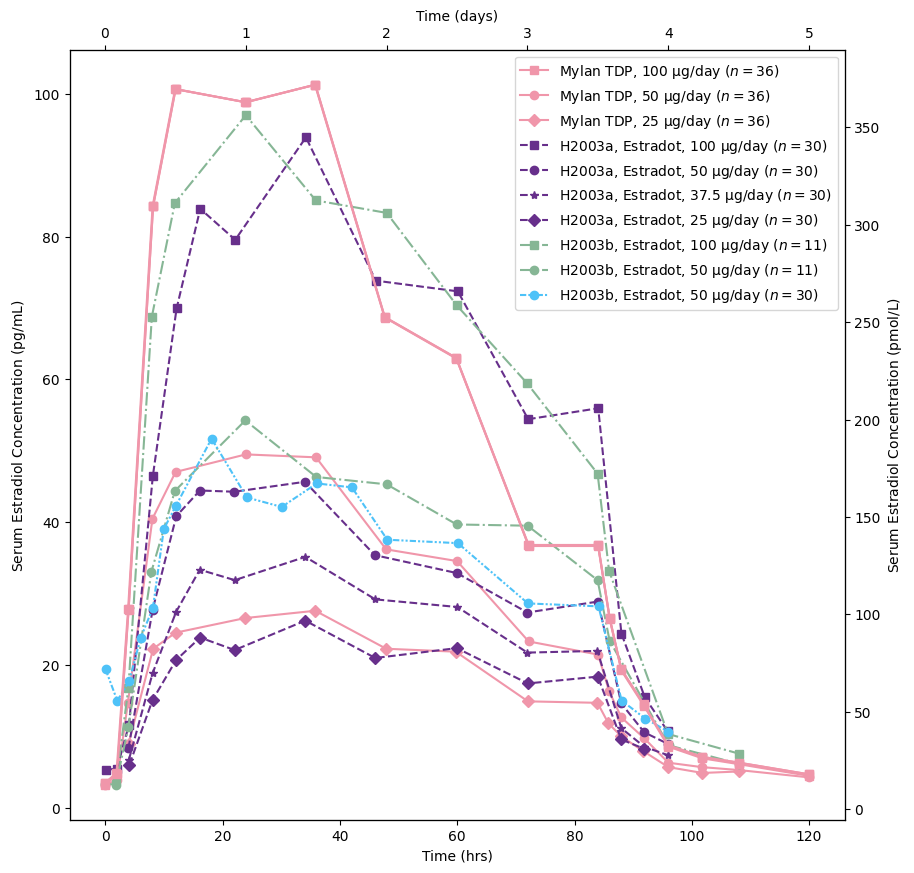

In [4]:
# plotting data obtained from literature

fig, ax1 = plt.subplots(figsize=(10,10))

# Mylan Estradiol TDP data
ax1.plot(MylanTDP100[:,0], MylanTDP100[:,1], color='#F096AA', marker='s', label="Mylan TDP, 100 $\\rm\\mu g$/day ($n=36$)")
ax1.plot(MylanTDP50[:,0], MylanTDP50[:,1], color='#F096AA', marker='o', label="Mylan TDP, 50 $\\rm\\mu g$/day ($n=36$)")
ax1.plot(MylanTDP25[:,0], MylanTDP25[:,1], color='#F096AA', marker='D', label="Mylan TDP, 25 $\\rm\\mu g$/day ($n=36$)")

# Hossain 2003a study, Estradot
ax1.plot(H2003aN30Estradot100[:,0], H2003aN30Estradot100[:,1], color='#672F8B', marker='s', linestyle='dashed', label="H2003a, Estradot, 100 $\\rm\\mu g$/day ($n=30$)")
ax1.plot(H2003aN30Estradot50[:,0], H2003aN30Estradot50[:,1], color='#672F8B', marker='o', linestyle='dashed', label="H2003a, Estradot, 50 $\\rm\\mu g$/day ($n=30$)")
ax1.plot(H2003aN30Estradot37_5[:,0], H2003aN30Estradot37_5[:,1], color='#672F8B', marker='*', linestyle='dashed', label="H2003a, Estradot, 37.5 $\\rm\\mu g$/day ($n=30$)")
ax1.plot(H2003aN30Estradot25[:,0], H2003aN30Estradot25[:,1], color='#672F8B', marker='D', linestyle='dashed', label="H2003a, Estradot, 25 $\\rm\\mu g$/day ($n=30$)")

# Hossain 2003b study, Estradot
ax1.plot(H2003bN11Estradot100[:,0], H2003bN11Estradot100[:,1], color='#86B695', marker='s', linestyle='dashdot', label="H2003b, Estradot, 100 $\\rm\\mu g$/day ($n=11$)")
ax1.plot(H2003bN11Estradot50[:,0], H2003bN11Estradot50[:,1], color='#86B695', marker='o', linestyle='dashdot', label="H2003b, Estradot, 50 $\\rm\\mu g$/day ($n=11$)")

# Hossain 2003b study, Estradot
ax1.plot(H2003bN30Estradot50[:,0], H2003bN30Estradot50[:,1], color='#4EC2F8', marker='o', linestyle=(0, (3, 1, 1, 1, 1, 1)), label="H2003b, Estradot, 50 $\\rm\\mu g$/day ($n=30$)")

ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Serum Estradiol Concentration ($\\rm pg/mL$)')
ax1.legend()

# 2nd y-axis in pmol/L rather than pg/mL
# https://transfemscience.org/misc/hormone-conc-unit-conv/
ax2 = ax1.twinx()
ax2.plot(MylanTDP100[:,0], MylanTDP100[:,1]*3.6713415, color='#F096AA', marker='s')
ax2.set_ylabel('Serum Estradiol Concentration ($\\rm pmol/L$)')

# 2nd x-axis in days rather than hrs
ax3 = ax1.twiny()
ax3.plot(MylanTDP100[:,0]/24, MylanTDP100[:,1], color='#F096AA', marker='s')
ax3.set_xlabel('Time (days)')

plt.show()

From the above plot, we can see the variability between estradiol patch brands exist. Of course, that could result from individual responses if we compare the study [H2003a](https://doi.org/10.1016/S0378-5122(03)00189-0) with [H2003b](https://doi.org/10.1016/S0378-5122(03)00190-7), in addition to two sample sizes within a single study [H2003b](https://doi.org/10.1016/S0378-5122(03)00190-7) at a dosage of $50\rm~\mu g/day$ ($n=11$ vs. $n=30$).

## Fitting the Literature Data

Next, we will fit the literature data to our model. We start with Mylan Estradiol TDP data, one fit for each dosage. Then moving on to Estradot studies, we will have one single fit for each dosage across different studies and sample sizes.

We have the solution to serum Estradiol concentration $E_2(t)$

\begin{align*}
    E_2(t) = &~k_1k_2D(t_0)\left[\frac{e^{-k_1t}}{(k_1-k_2)(k_1-k_3)} - \frac{e^{-k_2t}}{(k_1-k_2)(k_2-k_3)} + \frac{e^{-k_3t}}{(k_1-k_3)(k_2-k_3)}\right] \\
    &~+k_2A_{\rm eff}(t_0)\left[-\frac{e^{-k_2t}}{k_2-k_3} + \frac{e^{-k_3t}}{k_2-k_3}\right] + E_2(t_0)e^{-k_3t},
\end{align*}
where $A_{\rm eff}$ is a black box. We will leave the dosage units in mcg and leave the scaling to the fitting parameters.

In [5]:
# fitting function without A_{\rm eff}

def E2Dose(t, D0, k1, k2, k3):

    #Aeff0 = MylanTDP100[:,1][0]
    E20 = MylanTDP100[:,1][0]

    innerFunc1 = np.exp(-k1 * t) / ((k1 - k2) * (k1 - k3))
    innerFunc2 = np.exp(-k2 * t) / ((k1 - k2) * (k2 - k3))
    innerFunc3 = np.exp(-k3 * t) / ((k1 - k3) * (k2 - k3))
    DoseOut = D0 * (innerFunc1 - innerFunc2 + innerFunc3)

    # compute A_{\rm eff} term and E_2(t_0) term

    #Aeff0Out = k2 * Aeff0 * (-np.exp(-k2 * t)/(k2 - k3) + np.exp(-k3 * t)/(k2 - k3))
    E20Out = E20 * np.exp(-k3 * t)

    return k1 * k2 * DoseOut + E20Out

In [6]:
# here, we guess the initial fitting parameters based on https://www.desmos.com/calculator/ohsy9gslkn
# see https://discord.com/channels/438306949285806082/438308040446574592/1197997367518048336

pMylan100, covMylan100 = curve_fit(E2Dose, MylanTDP100[:,0], MylanTDP100[:,1],
                                   p0=[100,0.1,0.5,0.2], maxfev=5000)
                                    # bounds=((0,0,0,0), (100,1e3,1e3,1e3))

/tmp/ipykernel_3830/3498335623.py:9: RuntimeWarning: overflow encountered in exp
  innerFunc2 = np.exp(-k2 * t) / ((k1 - k2) * (k2 - k3))


In [7]:
# computing the fitted model for plotting
Mylan100Estimate = E2Dose(MylanTDP100[:,0], pMylan100[0], pMylan100[1], pMylan100[2], pMylan100[3])

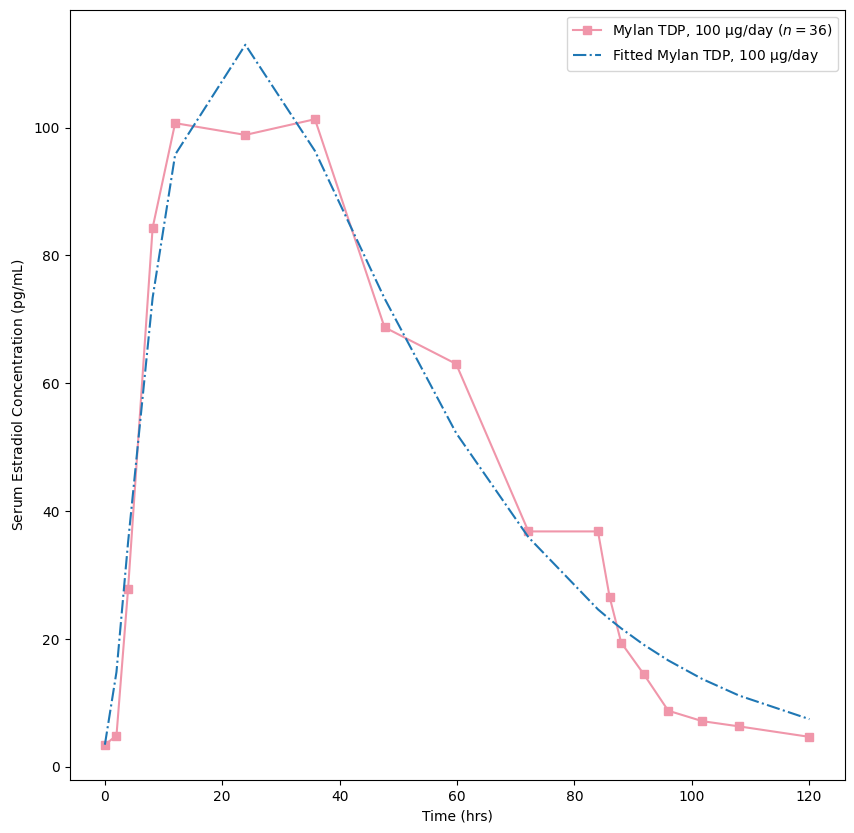

D0Hat = 222.35289750841216, k1Hat = 0.07079419089907138, k2Hat = 0.5745347853280945, k3Hat = 0.034308469036598656


In [8]:
# plotting data obtained from literature

fig, ax1 = plt.subplots(figsize=(10,10))

# Mylan Estradiol TDP data
ax1.plot(MylanTDP100[:,0], MylanTDP100[:,1], color='#F096AA', marker='s', label="Mylan TDP, 100 $\\rm\\mu g$/day ($n=36$)")
ax1.plot(MylanTDP100[:,0], Mylan100Estimate, linestyle='dashdot', label="Fitted Mylan TDP, 100 $\\rm\\mu g$/day")


ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Serum Estradiol Concentration ($\\rm pg/mL$)')
ax1.legend()
plt.show()

print(f'D0Hat = {pMylan100[0]}, k1Hat = {pMylan100[1]}, k2Hat = {pMylan100[2]}, k3Hat = {pMylan100[3]}')

Because we haven't converted our units to be consistent, $\hat D_0$ is not the dose.

In [9]:
# refining the model using lmfit, using fitted paramters from ...
# ... curve_fit as the initial guesses

Mylan100Model = Model(E2Dose)
print(f'parameter names: {Mylan100Model.param_names}')
print(f'independent variables: {Mylan100Model.independent_vars}')

parameter names: ['D0', 'k1', 'k2', 'k3']
independent variables: ['t']


In [76]:
# k_i can be greater than 1, from the likelihood surface using emcee
Mylan100Params = Mylan100Model.make_params(D0=dict(value=pMylan100[0],min=0,max=300),    # in mcg
                                           k1=dict(value=pMylan100[1],min=0,max=100,expr=''),
                                           k2=dict(value=pMylan100[2],min=0,max=100),
                                           k3=dict(value=pMylan100[3],min=0,max=100))
#Mylan100Model.set_param_hint('D0', vary=False)
Mylan100Fit = Mylan100Model.fit(data=MylanTDP100[:,1], params=Mylan100Params, t=MylanTDP100[:,0])

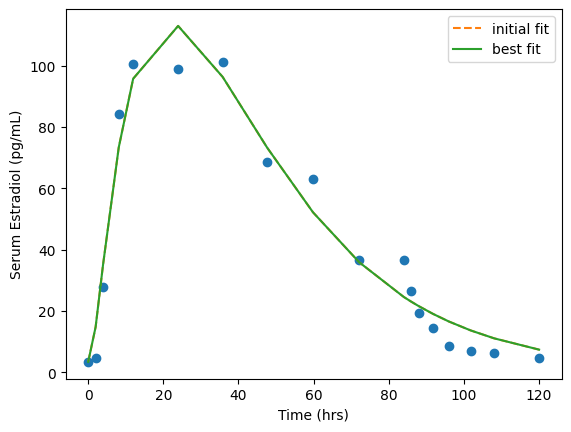

[[Model]]
    Model(E2Dose)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 18
    # variables        = 4
    chi-square         = 982.325624
    reduced chi-square = 70.1661160
    Akaike info crit   = 79.9919196
    Bayesian info crit = 83.5534066
    R-squared          = 0.95666068
[[Variables]]
    D0:  222.349516 +/- 59.6664839 (26.83%) (init = 222.3529)
    k1:  0.07079584 +/- 0.03272663 (46.23%) (init = 0.07079419)
    k2:  0.57454314 +/- 0.41823177 (72.79%) (init = 0.5745348)
    k3:  0.03430785 +/- 0.00975433 (28.43%) (init = 0.03430847)
[[Correlations]] (unreported correlations are < 0.100)
    C(D0, k3) = +0.9869
    C(D0, k1) = -0.9554
    C(k1, k3) = -0.9479
    C(k1, k2) = -0.7941
    C(D0, k2) = +0.6403
    C(k2, k3) = +0.6308


/home/ubuntu/venv310/lib/python3.10/site-packages/lmfit/confidence.py:317: UserWarning: Bound reached with prob(D0=300) = 0.37985708974970334 < max(sigmas)
  warn(errmsg)
/home/ubuntu/venv310/lib/python3.10/site-packages/lmfit/confidence.py:330: UserWarning: rel_change=-0.026961531536622837 < 1e-05 at iteration 5 and prob(k1=0.23442899222822763) = 0.8387385482308751 < max(sigmas)
  warn(errmsg)
/home/ubuntu/venv310/lib/python3.10/site-packages/lmfit/confidence.py:330: UserWarning: rel_change=9.86189785964737e-06 < 1e-05 at iteration 122 and prob(k2=51.598818620294544) = 0.9804168413713619 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 D0: -89.01523 -67.73663 -41.59079 222.34952      +inf      +inf      +inf
 k1:  -0.03471  -0.03025  -0.02603   0.07080  +0.04050      +inf      +inf
 k2:  -0.53846  -0.53400  -0.24722   0.57454  +0.50744  +3.00429      +inf
 k3:  -0.01484  -0.01123  -0.00685   0.03431  +0.01419  +0.01704  +0.02086


In [77]:
plt.plot(MylanTDP100[:,0], MylanTDP100[:,1], 'o')
plt.plot(MylanTDP100[:,0], Mylan100Fit.init_fit, '--', label='initial fit')
plt.plot(MylanTDP100[:,0], Mylan100Fit.best_fit, '-', label='best fit')
plt.xlabel('Time (hrs)')
plt.ylabel('Serum Estradiol (pg/mL)')
plt.legend()
plt.show()

print(Mylan100Fit.fit_report())
print(Mylan100Fit.ci_report())

By restricting the fitting parameters a priori, we obtained the same fit as that from `curve_fit` [with](https://discord.com/channels/438306949285806082/438308040446574592/1200609272233459772) $k_2 > k_3 > k_1$ (which is true for injectables where de-esterification being faster than unbinding + glucuronidation, which is in term faster than depot diffusion) as the initial guesses. But our fit resulted in $k_2>k_1>k_3$.

## Try emcee ([Bayesian Inference](https://en.wikipedia.org/wiki/Bayesian_inference))

The [default](https://emcee.readthedocs.io/en/v2.2.1/user/line/) likelihood function underlying the non-linear least square problem [is the](https://discord.com/channels/438306949285806082/438308040446574592/1200634578503749672) Gaussian function, which is the [default](https://discord.com/channels/438306949285806082/438308040446574592/1200664615500132562).

In [78]:
# https://lmfit.github.io/lmfit-py/examples/example_emcee_Model_interface.html
# burn means it's discarding the first 500 iterations/samples, and ...
# ... thin means its keeping every 20th sample, i.e. (10,000 - 500)/20 = 475, ...
# ... from result_emcee.lnprob.shape: (475, 100)
# see https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.Minimizer.emcee

emcee_kws = dict(steps=10000, burn=500, thin=20, is_weighted=False)
emcee_params = Mylan100Fit.params.copy()

# __lnsigma is the log of the standard deviation, here ~50 to 100, https://discord.com/channels/438306949285806082/438308040446574592/1200639243274440735
# __lnsigma characterizes the width/average error between the curves and the datapoints
# here, they also used the log trick to enforce the constraint that the standard deviation sigma should always be greater than 0
# it's the sigma in the gaussian model sum over datapoints (xi, ti)  exp(-1/2(xi - e2(ti, D0, k1, k2, k3))^2/sigma^2)/sqrt(2pi sigma^2)
# and they parametrize sigma = exp(__lnsigma)
# so a large sigma is more permissive in terms of the square error (xi - e2)^2, it penalizes large difference between the datapoint and the curve less.

emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(50))

In [79]:
result_emcee = Mylan100Model.fit(data=MylanTDP100[:,1], t=MylanTDP100[:,0],
                                 params=emcee_params, method='emcee',
                                 nan_policy='omit', fit_kws=emcee_kws)

100%|█████████████████████████████████████| 10000/10000 [01:43<00:00, 96.42it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [162.79871155 223.95394895 207.75416008 161.52405314  74.18937292]


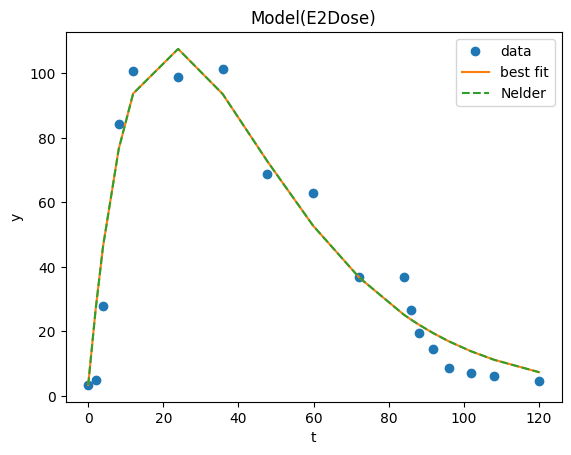

In [80]:
result_emcee.plot_fit()
plt.plot(MylanTDP100[:,0], Mylan100Model.eval(params=result_emcee.params, t=MylanTDP100[:,0]), '--', label='Nelder')
plt.legend()

Text(0, 0.5, 'acceptance fraction')

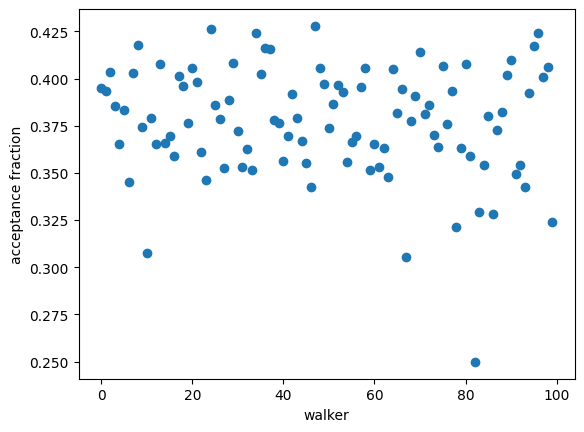

In [81]:
# Check the acceptance fraction to see whether emcee performed well
# https://lmfit.github.io/lmfit-py/examples/example_emcee_Model_interface.html

plt.plot(result_emcee.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')

In [85]:
lmfit.report_fit(result_emcee)

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 18
    # variables        = 5
    chi-square         = 16.3813622
    reduced chi-square = 1.26010478
    Akaike info crit   = 8.30390461
    Bayesian info crit = 12.7557634
    R-squared          = 0.99927727
[[Variables]]
    D0:         247.062544 +/- 39.1778524 (15.86%) (init = 222.3495)
    k1:         0.05367826 +/- 0.01195030 (22.26%) (init = 0.07079584)
    k2:         29.6698162 +/- 38.0041900 (128.09%) (init = 0.5745431)
    k3:         0.03830304 +/- 0.00626760 (16.36%) (init = 0.03430785)
    __lnsigma:  2.26108498 +/- 0.20173085 (8.92%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(D0, k3)        = +0.9333
    C(D0, k1)        = -0.7949
    C(k1, k3)        = -0.7582
    C(k1, k2)        = -0.2608
    C(k2, __lnsigma) = +0.2513


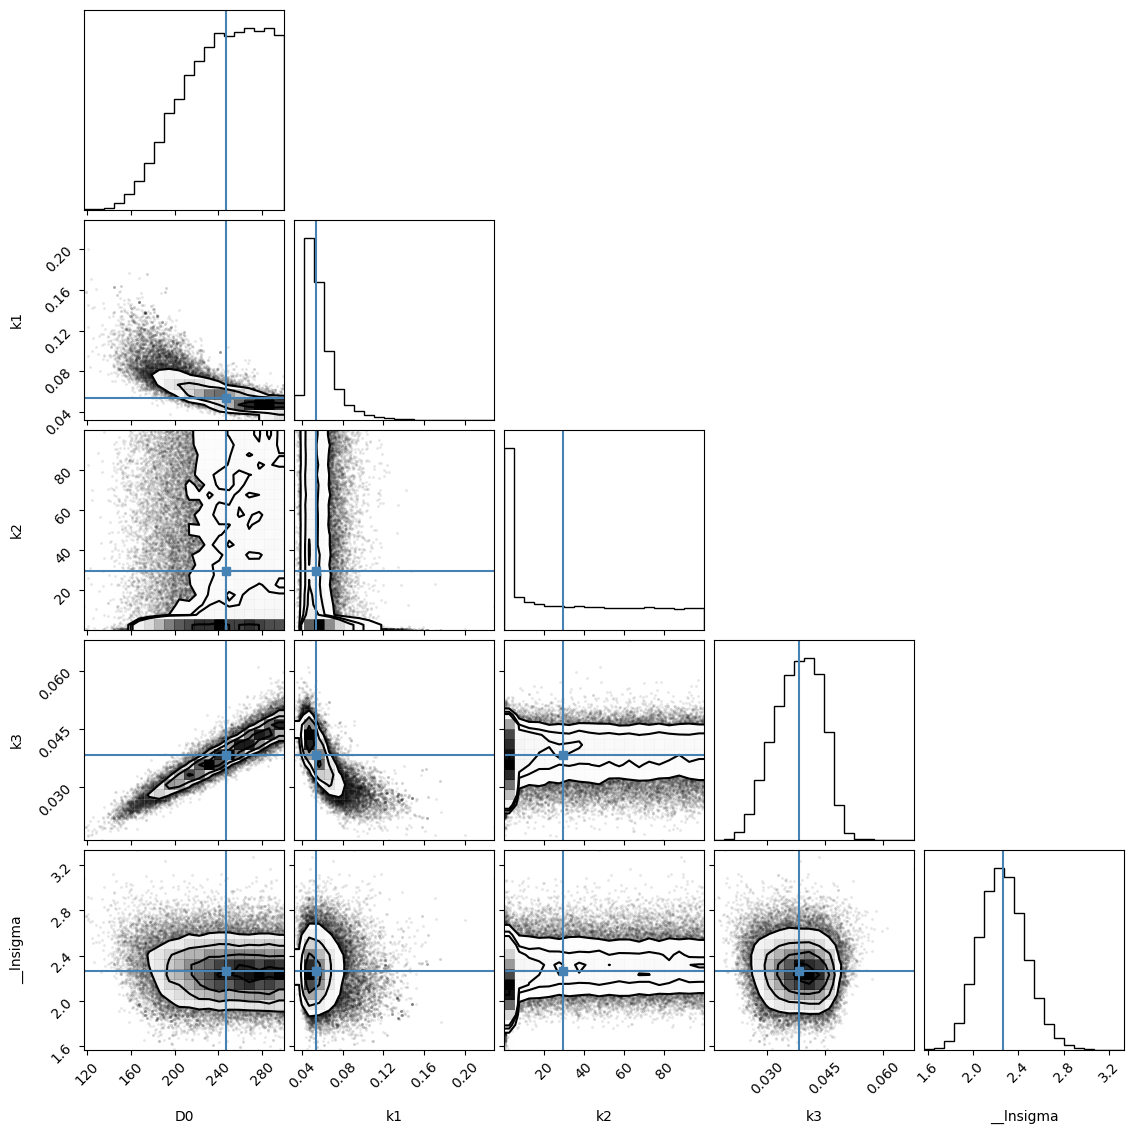

In [83]:
emcee_corner = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names,
                             truths=list(result_emcee.params.valuesdict().values()))

In [67]:
highest_prob = np.argmax(result_emcee.lnprob)
hp_loc = np.unravel_index(highest_prob, result_emcee.lnprob.shape)
mle_soln = result_emcee.chain[hp_loc]
print("\nMaximum Likelihood Estimation (MLE):")
print('----------------------------------')
for ix, param in enumerate(emcee_params):
    print(f"{param}: {mle_soln[ix]:.3f}")

quantiles = np.percentile(result_emcee.flatchain['k1'], [2.28, 15.9, 50, 84.2, 97.7])
print(f"\n\n1 sigma spread = {0.5 * (quantiles[3] - quantiles[1]):.3f}")
print(f"2 sigma spread = {0.5 * (quantiles[4] - quantiles[0]):.3f}")


Maximum Likelihood Estimation (MLE):
----------------------------------
D0: 224.689
k1: 0.591
k2: 0.070
k3: 0.035
__lnsigma: 2.011


1 sigma spread = 0.317
2 sigma spread = 0.446


In [109]:
# https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.Minimizer.emcee
# The result from emcee reports the median values, ...
# ... which are not necessarily the same as the Maximum Likelihood Estimate. ...
# ... To obtain the values for the Maximum Likelihood Estimation (MLE) we find ...
# ... the location in the chain with the highest probability
for i, par in enumerate(emcee_params):
    emcee_params[par].value = mle_soln[i]


print('\nMaximum Likelihood Estimation from emcee       ')
print('-------------------------------------------------')
print('Parameter  MLE Value   Median Value   Uncertainty')
fmt = '  {:5s}  {:11.5f} {:11.5f}   {:11.5f}'.format
for name, param in emcee_params.items():
    print(fmt(name, param.value, result_emcee.params[name].value,
              result_emcee.params[name].stderr))


Maximum Likelihood Estimation from emcee       
-------------------------------------------------
Parameter  MLE Value   Median Value   Uncertainty
  D0       224.68930   247.06254      39.17785
  k1         0.59138     0.05368       0.01195
  k2         0.06981    29.66982      38.00419
  k3         0.03475     0.03830       0.00627
  __lnsigma      2.01117     2.26108       0.20173


In [110]:
# Finally, we can use the samples from emcee to work out ...
# ... the 1- and 2- error estimates.

print('\nError estimates from emcee:')
print('------------------------------------------------------')
print('Parameter  -2sigma  -1sigma   median  +1sigma  +2sigma')

for name in emcee_params.keys():
    quantiles = np.percentile(result_emcee.flatchain[name],
                              [2.275, 15.865, 50, 84.135, 97.275])
    median = quantiles[2]
    err_m2 = quantiles[0] - median
    err_m1 = quantiles[1] - median
    err_p1 = quantiles[3] - median
    err_p2 = quantiles[4] - median
    fmt = '  {:5s}   {:8.4f} {:8.4f} {:8.4f} {:8.4f} {:8.4f}'.format
    print(fmt(name, err_m2, err_m1, median, err_p1, err_p2))



Error estimates from emcee:
------------------------------------------------------
Parameter  -2sigma  -1sigma   median  +1sigma  +2sigma
  D0      -76.5111 -42.2848 247.0625  36.0857  50.0276
  k1       -0.0135  -0.0083   0.0537   0.0156   0.0439
  k2      -29.2802 -28.6979  29.6698  47.3206  66.4024
  k3       -0.0123  -0.0067   0.0383   0.0058   0.0096
  __lnsigma    -0.3764  -0.1958   2.2611   0.2078   0.4177


~~So k2 > k1 > k3, which is probably fine for estradiol patches. (Need to check literature.)~~

Moreover, from the $k_1$ vs. $k_2$ scatter plot above, we see we have the [non-identifiability](https://discord.com/channels/438306949285806082/438308040446574592/1200653809219809371) issue where either $k_1$ or $k_2$ is degenerate.

With MCMC, we have [access](https://discord.com/channels/438306949285806082/438308040446574592/1200636886616641536) to the full posterior distribution over all the fitting parameters, not just a single point estimate. We can plot the [posterior distribution along the chain](https://discord.com/channels/438306949285806082/438308040446574592/1200654877542596719) by following [this](With MCMC, we have [access](https://discord.com/channels/438306949285806082/438308040446574592/1200636886616641536) to the full posterior distribution over all the fitting parameters, not just a single point estimate. We can plot the [posterior distribution along the chain](https://discord.com/channels/438306949285806082/438308040446574592/1200654877542596719) (`result_emcee.lnprob`) by following [this](https://emcee.readthedocs.io/en/v2.2.1/user/line/) if we are using `emcee` directly).

Here, we compute our model [over](https://discord.com/channels/438306949285806082/438308040446574592/1200690192017801236) a population of fitted paramters and then calculate the mean and standard deviation of estimated data points:

In [188]:
MylanTDP100ecmeeHat = np.zeros((np.size(MylanTDP100[:,0]), np.size(result_emcee.flatchain['D0'])))

for i in range(np.size(result_emcee.flatchain['D0'])):
    
    # extract fitted paramters
    #pMylanTDP100ecmeeHat = (result_emcee.flatchain["D0"][i], result_emcee.flatchain["k1"][i], result_emcee.flatchain["k2"][i], result_emcee.flatchain["k3"][i])

    # compute the model using the fitted parameters
    MylanTDP100ecmeeHat[:,i] = E2Dose(MylanTDP100[:,0], result_emcee.flatchain["D0"][i], 
                                      result_emcee.flatchain["k1"][i],
                                      result_emcee.flatchain["k2"][i],
                                      result_emcee.flatchain["k3"][i])

In [209]:
np.shape(MylanTDP100ecmeeHat)

(18, 47500)

In [210]:
np.size(MylanTDP100[:,0])

18

In [211]:
# compute the mean and standard deviation of estimated data points

MylanTDP100ecmeeHatStddev = np.zeros(np.size(MylanTDP100[:,0]))
MylanTDP100ecmeeHatMean = np.zeros(np.size(MylanTDP100[:,0]))

for i in range(np.size(MylanTDP100[:,0])):
    MylanTDP100ecmeeHatStddev[i] = np.std(MylanTDP100ecmeeHat[:,i])
    MylanTDP100ecmeeHatMean[i] = np.mean(MylanTDP100ecmeeHat[:,i])

MylanTDP100ecmeeHatStddev, MylanTDP100ecmeeHatMean

(array([34.0618025 , 29.34163132, 33.20086477, 36.69296059, 28.30125173,
        36.44762972, 31.23171139, 34.49837898, 33.77304534, 32.0384639 ,
        34.5449257 , 30.31950068, 30.43308185, 32.33960767, 28.24180254,
        32.72298164, 32.93731263, 27.04941599]),
 array([43.08090453, 42.4525855 , 38.70195734, 47.83942091, 36.90825662,
        39.81838375, 38.68839519, 42.81857507, 41.0900394 , 41.17187229,
        43.94202891, 37.97261896, 42.71058461, 41.76270362, 40.2309366 ,
        44.84432466, 39.23609385, 37.1343236 ]))

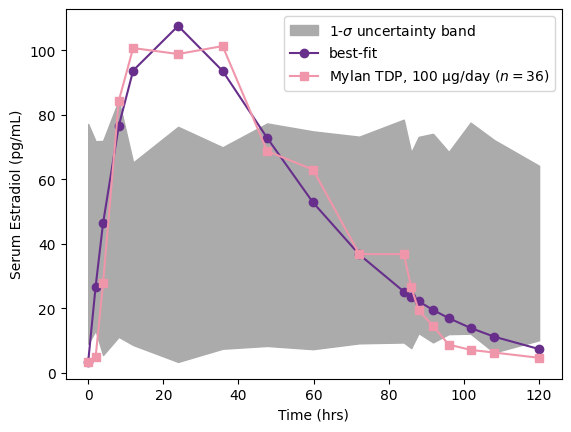

In [218]:
#dely1 = result_emcee.params[name].stderr
#dely = result_emcee.eval_uncertainty(t=MylanTDP100[:,0], sigma=3)

plt.fill_between(MylanTDP100[:,0], MylanTDP100ecmeeHatMean-MylanTDP100ecmeeHatStddev, MylanTDP100ecmeeHatMean+MylanTDP100ecmeeHatStddev, 
                 color="#ABABAB", label='1-$\sigma$ uncertainty band')
plt.plot(MylanTDP100[:,0], result_emcee.best_fit, label='best-fit', color='#672F8B', marker='o')
#bplt.scatter(MylanTDP100[:,0],result_emcee.best_fit)
plt.plot(MylanTDP100[:,0], MylanTDP100[:,1], color='#F096AA', marker='s', label="Mylan TDP, 100 $\\rm\\mu g$/day ($n=36$)")
plt.xlabel('Time (hrs)')
plt.ylabel('Serum Estradiol (pg/mL)')
plt.legend()
plt.show()

# Two-Compartment Model